## 01_EDA_MID_AmirHosseinMirzaei notebook

# 📝 Exploratory Data Analysis (EDA) on Medical Information Dataset

This notebook provides a comprehensive exploratory data analysis (EDA) on a medical information dataset. The primary objectives include understanding data distribution, identifying patterns, and uncovering insights that can guide further data processing and analysis.

### Objectives:

1. **Data Loading & Inspection**
   
2. **Therapeutic Class Distribution**
   
3. **Missing Value Detection**

4. **Word Frequency Analysis**

5. **Duplication Check**


## 📌 1. Load Data and Libraries

The first step involves importing necessary libraries and loading the datasets.

**Libraries**

**Datasets:**

- `MID.xlsx`
- `Therapeutic_class_counts-fXyUUS.xlsx`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import math
import re
import string
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

[nltk_data] Error loading punkt: <urlopen error [Errno 54] Connection
[nltk_data]     reset by peer>


True

In [3]:
mid_df = pd.read_excel('data/MID.xlsx')
class_counts_df = pd.read_excel('data/Therapeutic_class_counts-fXyUUS.xlsx')

## 📊 2. Basic Data Inspection

Let's inspect the structure of the data to understand its features and uncover any preliminary insights.

**Actions:**

- Display the shape and info of the MID dataset.
- Check for duplicate entries.


In [4]:
print("Shape of MID Dataset:", mid_df.shape)
print(mid_df.info())

Shape of MID Dataset: (192807, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192807 entries, 0 to 192806
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Name                 192807 non-null  object
 1   Link                 192807 non-null  object
 2   Contains             192807 non-null  object
 3   ProductIntroduction  180821 non-null  object
 4   ProductUses          192807 non-null  object
 5   ProductBenefits      192807 non-null  object
 6   SideEffect           192807 non-null  object
 7   HowToUse             192712 non-null  object
 8   HowWorks             192571 non-null  object
 9   QuickTips            192807 non-null  object
 10  SafetyAdvice         192807 non-null  object
 11  Chemical_Class       101473 non-null  object
 12  Habit_Forming        192807 non-null  object
 13  Therapeutic_Class    192807 non-null  object
 14  Action_Class         85690 non-null   object
dtyp

## 🔍 3. Duplication Analysis

Check and handle duplicate records.

**Actions:**

- Identify duplicate rows and fields.
- Optionally drop duplicates to clean data.

In [5]:
print("\n Duplicate rows:", mid_df.duplicated().sum())
print("\n Duplicate medicine names:", mid_df['Name'].duplicated().sum())


 Duplicate rows: 41791

 Duplicate medicine names: 44935


In [6]:
text_columns = ['ProductUses', 'SideEffect', 'ProductBenefits', 'HowWorks']

sample_display = mid_df.sample(1, random_state=42)[['Name'] + text_columns]
fig_table = go.Figure(data=[go.Table(
    header=dict(
        values=list(sample_display.columns),
        fill_color='lightblue',
        align='center',
        font=dict(size=14)
    ),
    cells=dict(
        values=[sample_display[col] for col in sample_display.columns],
        fill_color='lavender',
        align='left',
        font=dict(size=10),
        height=40
    )
)])
fig_table.update_layout(
    title="A sample of Medicine Data",
    height=400
)
fig_table.show()

## 🔍 4. Therapeutic Class Analysis

We will visualize the distribution of different therapeutic classes.

**Visualizations:**

- Bar plot showing class distribution.
- Optional pie chart for the top classes.

In [7]:
class_counts_df = class_counts_df.sort_values(by='Size', ascending=True)
fig_therapeutic = px.bar(
    class_counts_df, 
    x='Size', 
    y='Therapeutic_class',
    orientation='h',
    title='Therapeutic Class Distribution',
    labels={'Size': 'Number of Medicines', 'Therapeutic_class': 'Therapeutic Class'},
    color='Size',
    color_continuous_scale='Purp',
    hover_data=['Size']
)
fig_therapeutic.update_layout(height=800, showlegend=False)
fig_therapeutic.show()

In [8]:
top_5_classes = class_counts_df.nlargest(5, 'Size')
fig_pie = px.pie(
    top_5_classes, 
    values='Size', 
    names='Therapeutic_class',
    title='Top 5 Therapeutic Classes Distribution',
    hole=0.4
)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.show()


## 🔍 5. Missing Value Analysis

Identify columns with missing values.

**Steps:**

- Count missing values using `df.isnull().sum()`.
- Visualize missing data using a heatmap.

In [9]:
missing = mid_df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(mid_df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0]

In [10]:
fig_missing = px.bar(
    missing_df,
    x='Missing_Count',
    y='Column',
    orientation='h',
    title='Missing Values per Column',
    labels={'Missing_Count': 'Count of Missing Values'},
    color='Missing_Percentage',
    color_continuous_scale='Purp',
    hover_data=['Missing_Percentage']
)
fig_missing.update_layout(height=600)
fig_missing.show()


In [11]:
sample_df = mid_df.sample(min(100, len(mid_df)), random_state=42)
missing_matrix = sample_df.isnull().astype(int)

fig_heatmap = go.Figure(data=go.Heatmap(
    z=missing_matrix.T,
    x=list(range(len(sample_df))),
    y=missing_matrix.columns,
    colorscale=[[0, 'green'], [1, 'red']],
    showscale=False,
    hovertemplate='Row: %{x}<br>Column: %{y}<br>Missing: %{z}<extra></extra>'
))
fig_heatmap.update_layout(
    title='Data Completeness Heatmap (Sample of 100 rows)',
    xaxis_title='Row Index',
    yaxis_title='Column',
    height=600
)
fig_heatmap.show()

## 🔍 6. Word Frequency Analysis

Analyze word frequency across text columns.

**Process:**

- Tokenize text and conduct frequency analysis.
- Visualize results using bar plots and word clouds.

In [12]:
text_lengths = {}
for col in text_columns:
    text_lengths[col] = mid_df[col].fillna('').str.len()

fig_text_dist = make_subplots(
    rows=2, cols=2,
    subplot_titles=text_columns,
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

colors = ['blue', 'green', 'orange', 'red']
for i, col in enumerate(text_columns):
    row = i // 2 + 1
    col_idx = i % 2 + 1
    lengths = text_lengths[col]
    
    fig_text_dist.add_trace(
        go.Histogram(
            x=lengths,
            name=f"{col} Histogram",
            nbinsx=60,
            marker_color=colors[i],
            opacity=0.3
        ),
        row=row, col=col_idx
    )

    kde = gaussian_kde(lengths, bw_method=0.3)
    x_vals = np.linspace(lengths.min(), lengths.max(), 80)
    y_vals = kde(x_vals) * len(lengths) * (x_vals[1] - x_vals[0])

    fig_text_dist.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            name=f"{col} KDE ",
            mode='lines',
            line=dict(color=colors[i], width=3),
        ),
        row=row, col=col_idx
    )

fig_text_dist.update_layout(
    title_text="Text Length Distribution with KDE",
    showlegend=False,
    height=800
)
fig_text_dist.update_xaxes(title_text="Character Count")
fig_text_dist.update_yaxes(title_text="Frequency")
fig_text_dist.show()

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

In [14]:
text_data = mid_df[text_columns].fillna("").apply(lambda x: ' '.join(x.astype(str)), axis=1)
cleaned_text = text_data.apply(clean_text)

stop_words = set(stopwords.words('english'))
all_words = []

for doc in cleaned_text:
    tokens = word_tokenize(doc)
    filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
    all_words.extend(filtered)

word_freq = Counter(all_words)
most_common = word_freq.most_common(30)

In [15]:
words_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
fig_words = px.bar(
    words_df.iloc[::-1], 
    x='Frequency', 
    y='Word',
    orientation='h',
    title='Top 30 Most Frequent Words in Medicine Descriptions',
    color='Frequency',
    color_continuous_scale='Purp',
    hover_data=['Frequency']
)
fig_words.update_layout(height=800, showlegend=False)
fig_words.show()

In [16]:
column_word_freq = {}
for col in text_columns:
    col_text = mid_df[col].fillna('').apply(clean_text)
    col_words = []
    for doc in col_text:
        tokens = word_tokenize(doc)
        filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
        col_words.extend(filtered)
    column_word_freq[col] = Counter(col_words).most_common(10)

In [17]:
fig_col_words = make_subplots(
    rows=2, cols=2,
    subplot_titles=text_columns,
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

colors = ['blue', 'green', 'orange', 'red']
for i, col in enumerate(text_columns):
    row = i // 2 + 1
    col_idx = i % 2 + 1
    
    words, freqs = zip(*column_word_freq[col])
    fig_col_words.add_trace(
        go.Bar(
            x=list(freqs),
            y=list(words),
            orientation='h',
            marker_color=colors[i],
            name=col,
            text=list(freqs),
            textposition='outside'
        ),
        row=row, col=col_idx
    )

fig_col_words.update_layout(
    title_text="Top 10 Words by Text Column",
    showlegend=False,
    height=1000
)
fig_col_words.update_xaxes(title_text="Frequency")
fig_col_words.show()

## 🔍 07. WordCloud

In this step, we will generate a WordCloud visualization to highlight the most frequently appearing words across specified text columns. The size of each word reflects its frequency in the dataset.

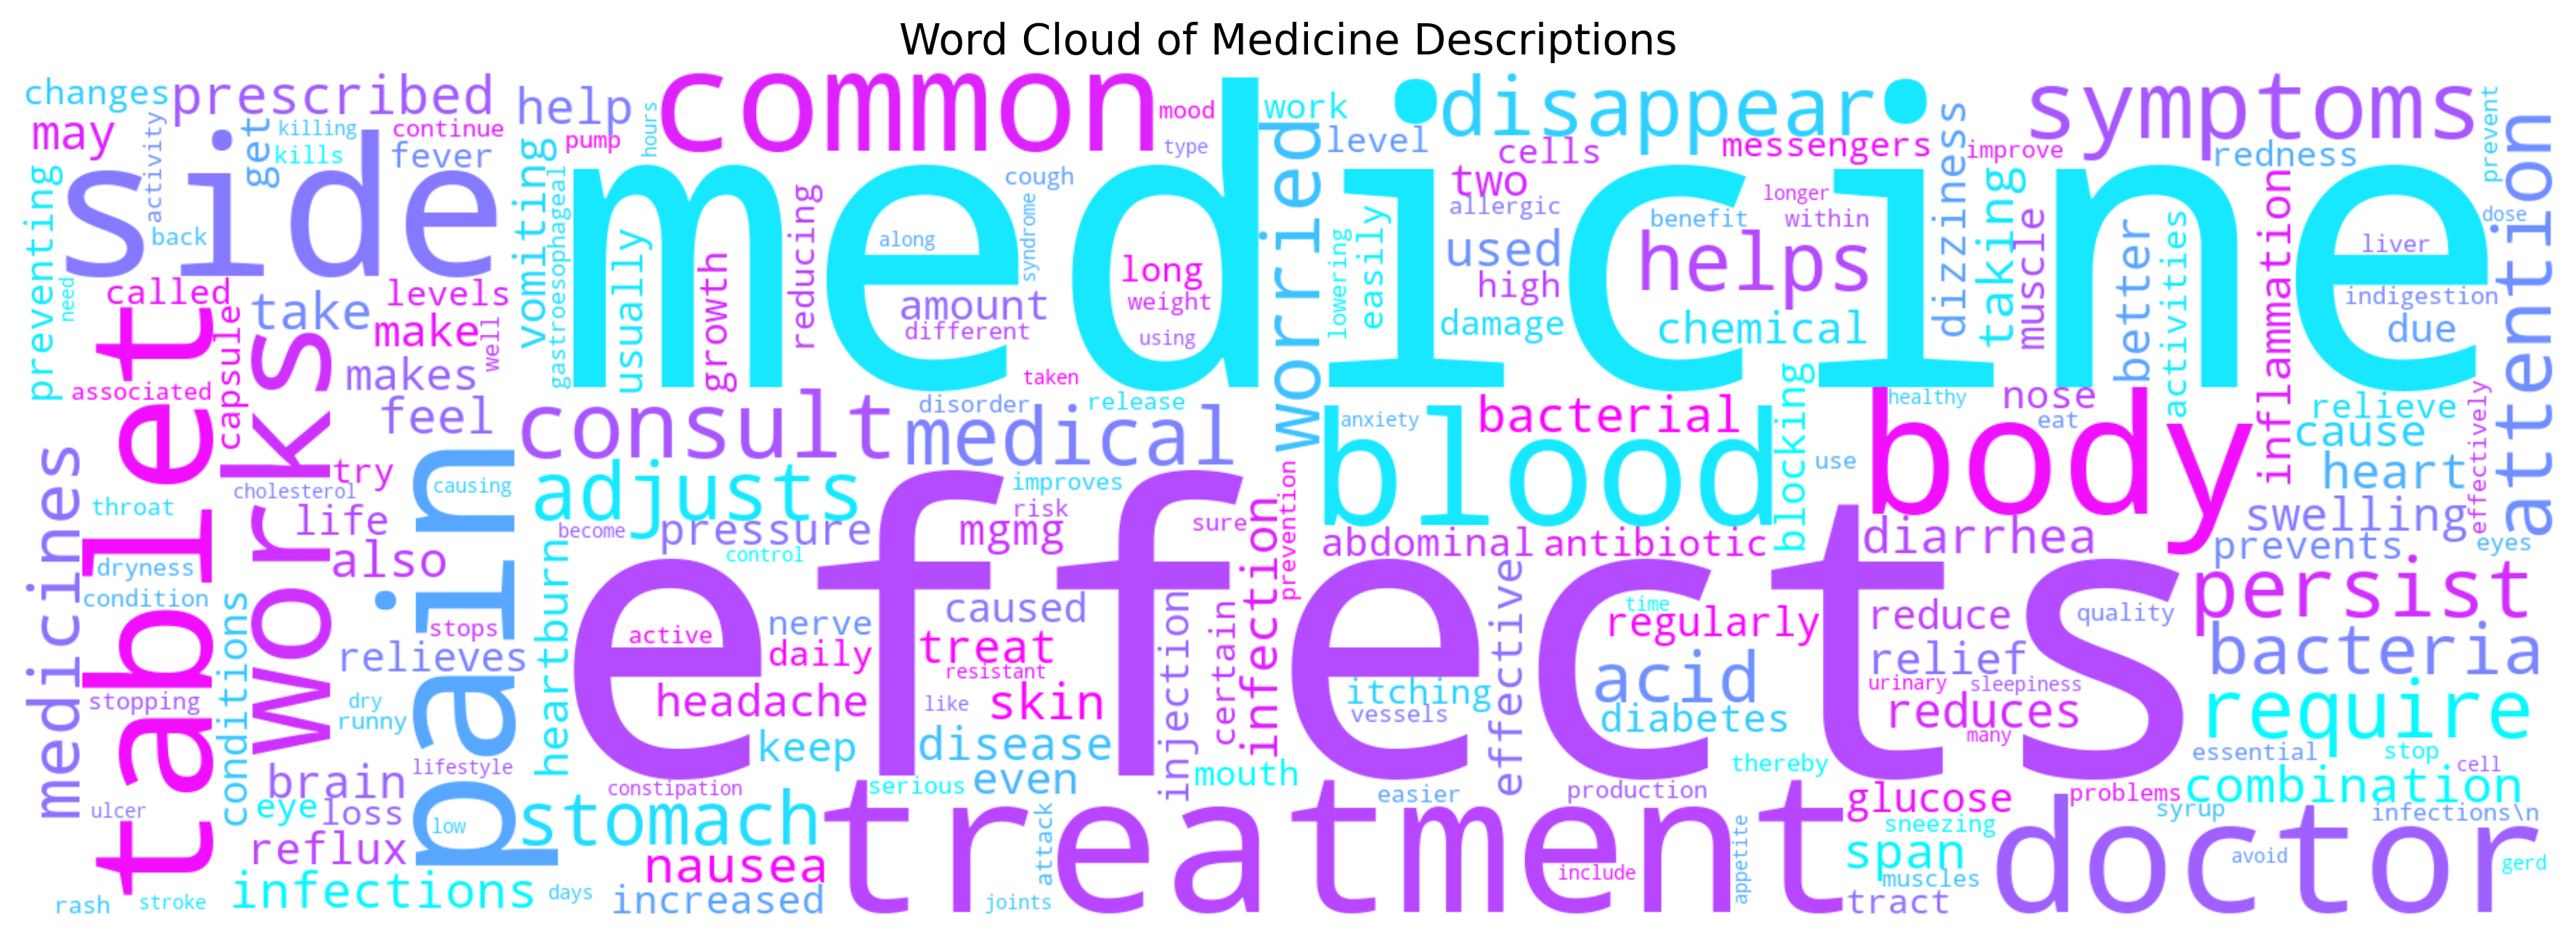

In [18]:
wordcloud = WordCloud(
                        width=1800, 
                        height=600, 
                        background_color='white',
                        colormap='cool'
                        ).generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 8), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Medicine Descriptions", fontsize=14)
plt.show()

In [19]:
print("\n=== Summary Statistics ===")
print(f"Total number of medicines: {len(mid_df)}")
print(f"Total number of therapeutic classes: {len(class_counts_df)}")
print(f"Average medicines per therapeutic class: {class_counts_df['Size'].mean():.2f}")
print(f"Most common therapeutic class: {class_counts_df.iloc[0]['Therapeutic_class']} ({class_counts_df.iloc[0]['Size']} medicines)")
print(f"\nText completeness:")
for col in text_columns:
    completeness = (mid_df[col].notna().sum() / len(mid_df)) * 100
    print(f"  {col}: {completeness:.1f}% complete")



=== Summary Statistics ===
Total number of medicines: 192807
Total number of therapeutic classes: 44
Average medicines per therapeutic class: 4381.98
Most common therapeutic class: STOMATOLOGICALS (12 medicines)

Text completeness:
  ProductUses: 100.0% complete
  SideEffect: 100.0% complete
  ProductBenefits: 100.0% complete
  HowWorks: 99.9% complete


## 💾 08. Save excel files into csv files

In [20]:
mid_df.to_csv('data/MID_data.csv', index=False)
print("\nSaved MID data to 'data/MID_data.csv' ✅")

class_counts_df.iloc[:, :2].to_csv('data/therapeutic_classes.csv', index=False)
print("\nSaved therapeutic classes to 'data/therapeutic_classes.csv' ✅")


Saved MID data to 'data/MID_data.csv' ✅

Saved therapeutic classes to 'data/therapeutic_classes.csv' ✅


In [21]:
mid_df['Name_Length'] = mid_df['Name'].str.len()
mid_df['Name_Word_Count'] = mid_df['Name'].str.split().str.len()
mid_df['Has_Numbers'] = mid_df['Name'].str.contains(r'\d', na=False)
mid_df['Has_Parentheses'] = mid_df['Name'].str.contains(r'\(|\)', na=False)

In [22]:
fig_patterns = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Name Length Distribution', 'Word Count Distribution', 
                   'Names with Numbers', 'Names with Parentheses'],
    specs=[[{'type': 'histogram'}, {'type': 'histogram'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

fig_patterns.add_trace(
    go.Histogram(x=mid_df['Name_Length'], nbinsx=50, marker_color='blue'),
    row=1, col=1
)
fig_patterns.add_trace(
    go.Histogram(x=mid_df['Name_Word_Count'], nbinsx=10, marker_color='green'),
    row=1, col=2
)

num_counts = mid_df['Has_Numbers'].value_counts()
fig_patterns.add_trace(
    go.Bar(x=['Without Numbers', 'With Numbers'], 
           y=[num_counts[False], num_counts[True]], 
           marker_color=['gray', 'orange']),
    row=2, col=1
)

paren_counts = mid_df['Has_Parentheses'].value_counts()
fig_patterns.add_trace(
    go.Bar(x=['Without Parentheses', 'With Parentheses'], 
           y=[paren_counts[False], paren_counts[True]], 
           marker_color=['gray', 'purple']),
    row=2, col=2
)

fig_patterns.update_layout(
    title_text="Medicine Name Pattern Analysis",
    showlegend=False,
    height=800
)
fig_patterns.show()

## 🔍 09. Sentiment Intensity Analyzer

This section employs the Sentiment Intensity Analyzer from the `nltk` library to evaluate sentiment scores of specified text data. Understanding sentiment can guide further analysis for potential patterns and insights.

In [23]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    """Calculate sentiment scores for text"""
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(str(text))

sentiment_results = {}
for col in text_columns:
    sentiments = mid_df[col].apply(get_sentiment_scores)
    sentiment_df = pd.DataFrame(list(sentiments))
    sentiment_results[col] = sentiment_df

In [24]:
fig_sentiment = go.Figure()
for col in text_columns:
    avg_sentiment = sentiment_results[col].mean()
    fig_sentiment.add_trace(go.Bar(
        name=col,
        x=['Negative', 'Neutral', 'Positive', 'Compound'],
        y=[avg_sentiment['neg'], avg_sentiment['neu'], avg_sentiment['pos'], avg_sentiment['compound']]
    ))

fig_sentiment.update_layout(
    title='Average Sentiment Scores by Text Column',
    xaxis_title='Sentiment Type',
    yaxis_title='Average Score',
    barmode='group'
)
fig_sentiment.show()


## 🔍 10. Most Common Bigrams

Next, we delve into bi-gram analysis to identify the most common pairs of consecutive words in the dataset. This can uncover prevalent phrases and relationships within the text data.

In [25]:
def get_ngrams(text, n):
    """Get n-grams from text"""
    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2 and w.isalpha()]
    return list(ngrams(tokens, n))

all_bigrams = []
for doc in cleaned_text:
    all_bigrams.extend(get_ngrams(doc, 2))

bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(20)

bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
bigram_counts = [count for _, count in top_bigrams]

fig_bigrams = px.bar(
    x=bigram_counts[::-1],
    y=bigram_labels[::-1],
    orientation='h',
    title='Top 20 Most Common Bigrams',
    labels={'x': 'Frequency', 'y': 'Bigram'},
    color=bigram_counts[::-1],
    color_continuous_scale='Purp'
)
fig_bigrams.update_layout(height=600, showlegend=False)
fig_bigrams.show()


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

sample_size = min(1000, len(mid_df))
sample_docs = cleaned_text.sample(sample_size, random_state=42)

vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(sample_docs)
feature_names = vectorizer.get_feature_names_out()

avg_tfidf = tfidf_matrix.mean(axis=0).A1
tfidf_df = pd.DataFrame({
    'term': feature_names,
    'tfidf': avg_tfidf
}).sort_values('tfidf', ascending=False)

fig_tfidf = px.bar(
    tfidf_df.head(20).iloc[::-1],
    x='tfidf',
    y='term',
    orientation='h',
    title='Top 20 Terms by Average TF-IDF Score',
    labels={'tfidf': 'Average TF-IDF Score', 'term': 'Term'},
    color='tfidf',
    color_continuous_scale='Purp'
)
fig_tfidf.update_layout(height=600, showlegend=False)
fig_tfidf.show()


In [27]:
mid_df['Name_Suffix'] = mid_df['Name'].str.extract(r'(\w{3})$', expand=False)
suffix_counts = mid_df['Name_Suffix'].value_counts().head(5)

fig_suffix = px.pie(
    values=suffix_counts.values,
    names=suffix_counts.index,
    title='Top 5 Most Common Medicine Name Suffixes(Last 3 letters)'
    )
fig_suffix.update_traces(textposition='inside', textinfo='percent+label')
fig_suffix.show()

## 🔍 11. Word Co-occurrence Network

Here, we visualize relationships between frequently occurring words using a word co-occurrence network. This graph-based visualization offers insights into common co-occurrences, revealing potential thematic clusters.

**Steps:**

- Construct a network using `networkx`.
- Use edge weights to reflect co-occurrence frequency.
- Visualize the network to identify key connections and clusters.

In [28]:
top_words = [word for word, _ in most_common[:20]]
cooccurrence = np.zeros((len(top_words), len(top_words)))

for doc in cleaned_text.sample(min(500, len(cleaned_text))):
    doc_words = word_tokenize(doc)
    doc_words = [w for w in doc_words if w in top_words]
    for i, word1 in enumerate(doc_words):
        for j, word2 in enumerate(doc_words[i+1:i+5], i+1):
            if word1 in top_words and word2 in top_words:
                idx1 = top_words.index(word1)
                idx2 = top_words.index(word2)
                cooccurrence[idx1][idx2] += 1
                cooccurrence[idx2][idx1] += 1

G = nx.Graph()
for i, word1 in enumerate(top_words):
    for j, word2 in enumerate(top_words[i+1:], i+1):
        weight = cooccurrence[i][j]
        if weight > 20:
            G.add_edge(word1, word2, weight=weight)

pos = nx.spring_layout(G, k=1, iterations=50)
edge_trace = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = edge[2]['weight']

    edge_trace.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(
            width=2,
            color='rgba(128, 0, 128, 0.3)'
        ),
        hoverinfo='none'
    ))

node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    text=[node for node in G.nodes()],
    textposition="top center",
    marker=dict(
        size=20,
        color='darkblue',
        line=dict(color='white', width=0.5)
    )
)

fig_network = go.Figure(data=edge_trace + [node_trace])
fig_network.update_layout(
    title='Word Co-occurrence Network',
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=600
)
fig_network.show()

## 🔑Conclusion

The exploratory data analysis has provided valuable insights into the medicine dataset, including therapeutic class distributions, missing values, text analysis, and visualizations. The results are saved for further exploration and reporting.